# Emo-DB Dataset Speech Emotion Detection

This is an audio classification notebook for the Emo-DB Database. I have performed EDA for the dataset.

# About Dataset

Emo-DB Database
The EMODB database is the freely available German emotional database. The database is created by the Institute of Communication Science, Technical University, Berlin, Germany. Ten professional speakers (five males and five females) participated in data recording. The database contains a total of 535 utterances. The EMODB database comprises of seven emotions: 1) anger; 2) boredom; 3) anxiety; 4) happiness; 5) sadness; 6) disgust; and 7) neutral. The data was recorded at a 48-kHz sampling rate and then down-sampled to 16-kHz.

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2024-04-23 04:18:45.962314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 04:18:45.962428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 04:18:46.080401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Observation

In [2]:
# Define the paths to the data directories
BASE_DIR = Path('/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/')


filepaths = list(BASE_DIR.glob('*.wav'))

In [3]:
# identify emotions from the files names
audio_files = [path.name for path in filepaths]
emotion_label = [filename[5] for filename in audio_files]
print(emotion_label)

['F', 'F', 'W', 'W', 'W', 'A', 'W', 'T', 'W', 'W', 'L', 'N', 'W', 'L', 'L', 'F', 'N', 'E', 'A', 'A', 'W', 'F', 'W', 'W', 'N', 'L', 'E', 'L', 'N', 'W', 'A', 'W', 'W', 'L', 'F', 'T', 'W', 'F', 'F', 'W', 'L', 'T', 'E', 'W', 'W', 'E', 'W', 'A', 'T', 'F', 'W', 'A', 'F', 'A', 'F', 'A', 'F', 'N', 'W', 'T', 'E', 'W', 'F', 'T', 'A', 'E', 'F', 'N', 'A', 'T', 'A', 'F', 'L', 'A', 'E', 'W', 'W', 'E', 'N', 'A', 'A', 'T', 'W', 'N', 'E', 'L', 'N', 'N', 'L', 'W', 'F', 'A', 'A', 'N', 'W', 'N', 'W', 'F', 'F', 'W', 'A', 'N', 'W', 'L', 'F', 'N', 'E', 'W', 'L', 'W', 'E', 'W', 'F', 'A', 'W', 'L', 'L', 'A', 'F', 'E', 'N', 'L', 'W', 'L', 'A', 'L', 'W', 'W', 'W', 'W', 'T', 'W', 'T', 'A', 'L', 'T', 'T', 'W', 'E', 'W', 'W', 'W', 'F', 'L', 'A', 'E', 'W', 'L', 'L', 'E', 'L', 'N', 'W', 'T', 'N', 'W', 'T', 'W', 'W', 'N', 'N', 'A', 'L', 'L', 'E', 'N', 'W', 'N', 'A', 'W', 'L', 'L', 'A', 'L', 'W', 'F', 'W', 'A', 'A', 'W', 'N', 'W', 'W', 'L', 'L', 'F', 'L', 'F', 'A', 'W', 'L', 'N', 'F', 'W', 'W', 'N', 'W', 'F', 'F', 'L',

In [4]:
# renaming emotions to make a proper sense

emotion_dict = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'anxiety/fear',
        'F': 'happiness',
        'T': 'sadness',
        'N' : 'neutral version'
    }

for item in range(len(emotion_label)):
    val = emotion_dict[emotion_label[item]]
    emotion_label[item] = val
print(emotion_label)

['happiness', 'happiness', 'anger', 'anger', 'anger', 'anxiety/fear', 'anger', 'sadness', 'anger', 'anger', 'boredom', 'neutral version', 'anger', 'boredom', 'boredom', 'happiness', 'neutral version', 'disgust', 'anxiety/fear', 'anxiety/fear', 'anger', 'happiness', 'anger', 'anger', 'neutral version', 'boredom', 'disgust', 'boredom', 'neutral version', 'anger', 'anxiety/fear', 'anger', 'anger', 'boredom', 'happiness', 'sadness', 'anger', 'happiness', 'happiness', 'anger', 'boredom', 'sadness', 'disgust', 'anger', 'anger', 'disgust', 'anger', 'anxiety/fear', 'sadness', 'happiness', 'anger', 'anxiety/fear', 'happiness', 'anxiety/fear', 'happiness', 'anxiety/fear', 'happiness', 'neutral version', 'anger', 'sadness', 'disgust', 'anger', 'happiness', 'sadness', 'anxiety/fear', 'disgust', 'happiness', 'neutral version', 'anxiety/fear', 'sadness', 'anxiety/fear', 'happiness', 'boredom', 'anxiety/fear', 'disgust', 'anger', 'anger', 'disgust', 'neutral version', 'anxiety/fear', 'anxiety/fear', 

In [5]:
# appending emotion_label for the audio dataframe
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(emotion_label, name='Label')


audio_df = pd.concat([filepaths, labels], axis=1)
audio_df['Index'] = audio_df.index
print(audio_df)


                                              Filepath            Label  Index
0    /kaggle/input/berlin-database-of-emotional-spe...        happiness      0
1    /kaggle/input/berlin-database-of-emotional-spe...        happiness      1
2    /kaggle/input/berlin-database-of-emotional-spe...            anger      2
3    /kaggle/input/berlin-database-of-emotional-spe...            anger      3
4    /kaggle/input/berlin-database-of-emotional-spe...            anger      4
..                                                 ...              ...    ...
530  /kaggle/input/berlin-database-of-emotional-spe...  neutral version    530
531  /kaggle/input/berlin-database-of-emotional-spe...          boredom    531
532  /kaggle/input/berlin-database-of-emotional-spe...          sadness    532
533  /kaggle/input/berlin-database-of-emotional-spe...  neutral version    533
534  /kaggle/input/berlin-database-of-emotional-spe...        happiness    534

[535 rows x 3 columns]


In [6]:
audio_df.head()

,Filepath,Label,Index
0,/kaggle/input/berlin-database-of-emotional-spe...,happiness,0
1,/kaggle/input/berlin-database-of-emotional-spe...,happiness,1
2,/kaggle/input/berlin-database-of-emotional-spe...,anger,2
3,/kaggle/input/berlin-database-of-emotional-spe...,anger,3
4,/kaggle/input/berlin-database-of-emotional-spe...,anger,4


# Dataset Visualization

<Axes: xlabel='Label', ylabel='Count'>

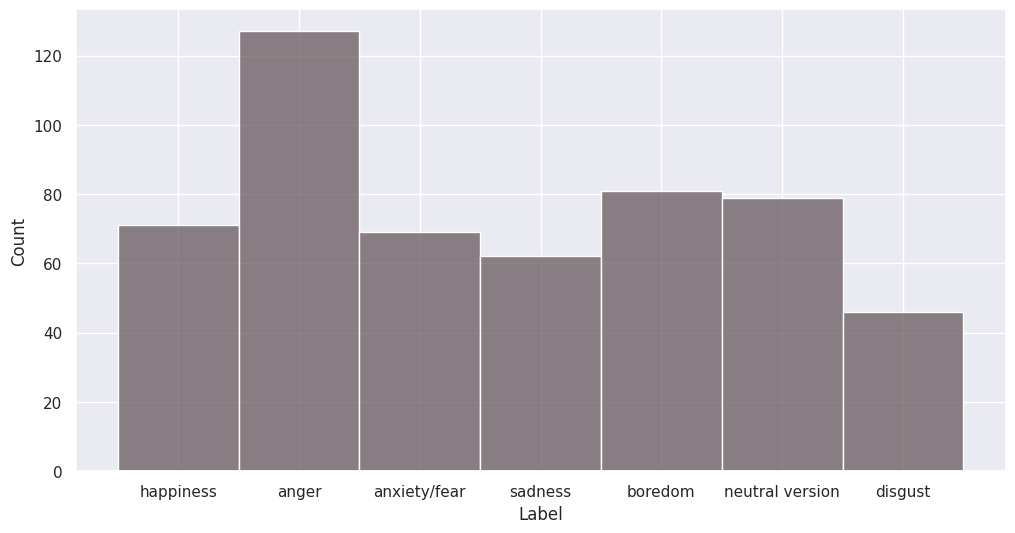

In [7]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style('darkgrid')
sns.histplot(labels, color='#67595E')

In [8]:
audio_arrays = []

for i in audio_df['Filepath']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
audio_df['Arrays'] = audio_arrays

In [9]:
audio_df

,Filepath,Label,Index,Arrays
0,/kaggle/input/berlin-database-of-emotional-spe...,happiness,0,"[7.910709e-06, 2.9645864e-05, 4.6679696e-05, 5..."
1,/kaggle/input/berlin-database-of-emotional-spe...,happiness,1,"[7.711279e-05, 8.140653e-05, 7.731386e-05, 0.0..."
2,/kaggle/input/berlin-database-of-emotional-spe...,anger,2,"[-5.8388637e-06, -3.6711e-05, -6.197962e-05, -..."
3,/kaggle/input/berlin-database-of-emotional-spe...,anger,3,"[3.7577483e-06, 1.5163231e-05, 1.4789733e-05, ..."
4,/kaggle/input/berlin-database-of-emotional-spe...,anger,4,"[0.0003161472, 0.00037248555, 0.00027575568, 0..."
...,...,...,...,...
530,/kaggle/input/berlin-database-of-emotional-spe...,neutral version,530,"[-7.3725016e-05, -0.00028470083, -0.0005345309..."
531,/kaggle/input/berlin-database-of-emotional-spe...,boredom,531,"[0.00018496785, 0.00015258142, 4.274217e-05, 2..."
532,/kaggle/input/berlin-database-of-emotional-spe...,sadness,532,"[0.00026571756, 0.00045055113, 0.0005573313, 0..."
533,/kaggle/input/berlin-database-of-emotional-spe...,neutral version,533,"[0.00011007575, 3.156803e-05, -0.00013938424, ..."


# Anger

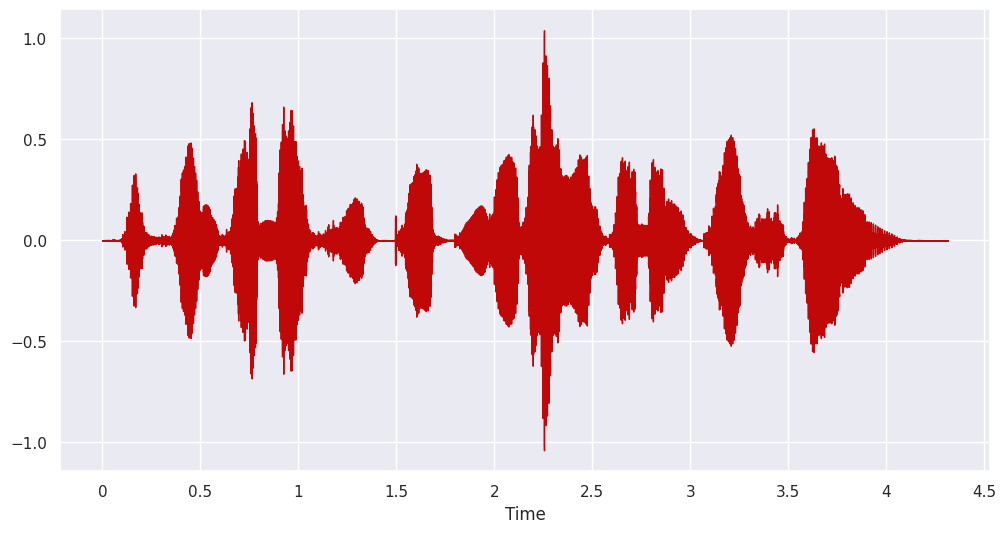

In [10]:
angfile = audio_df[audio_df['Label'] == 'anger']['Filepath']
angarray = audio_df[audio_df['Label'] == 'anger']['Arrays']

librosa.display.waveshow(angarray.iloc[0], color='#C00808')
IPython.display.Audio(angfile.iloc[0])

# Boredom

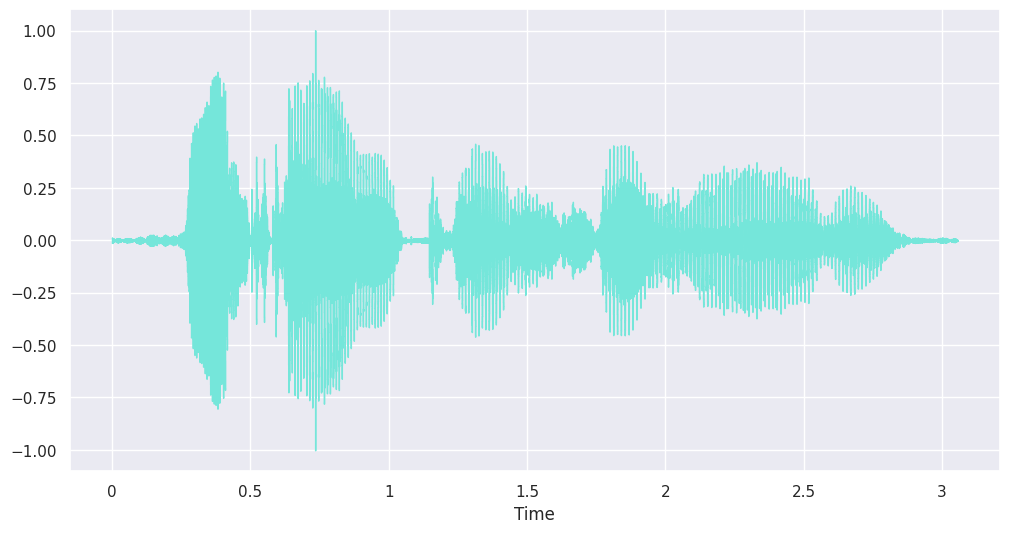

In [11]:
boredom = audio_df[audio_df['Label'] == 'boredom']['Filepath']
boredomarray = audio_df[audio_df['Label'] == 'boredom']['Arrays']

librosa.display.waveshow(boredomarray.iloc[0], color='#75E6DA')
IPython.display.Audio(boredom.iloc[0])

# Sadness

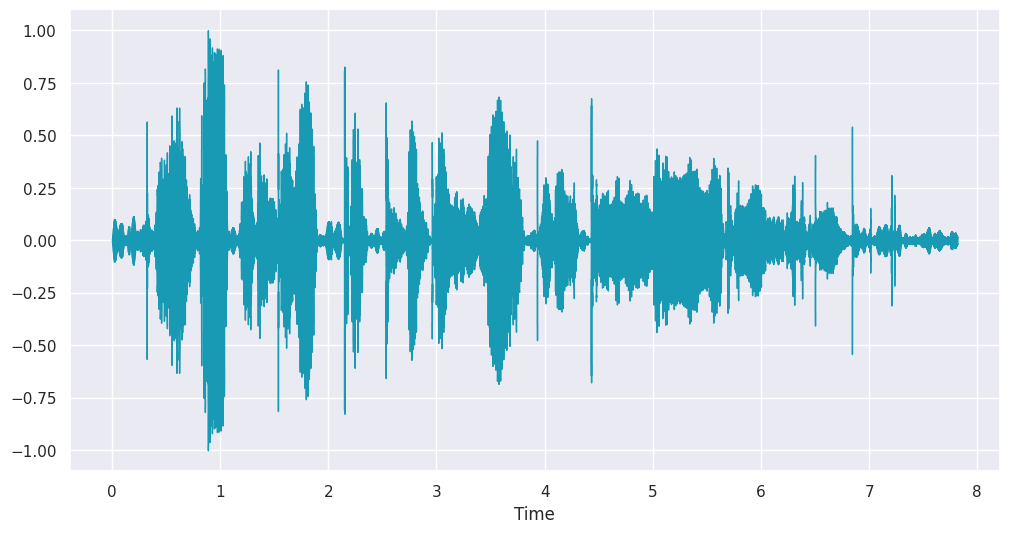

In [12]:
sadness = audio_df[audio_df['Label'] == 'sadness']['Filepath']
sadnessarray = audio_df[audio_df['Label'] == 'sadness']['Arrays']

librosa.display.waveshow(sadnessarray.iloc[0], color='#189AB4')
IPython.display.Audio(sadness.iloc[0])

# Anxiety/Fear

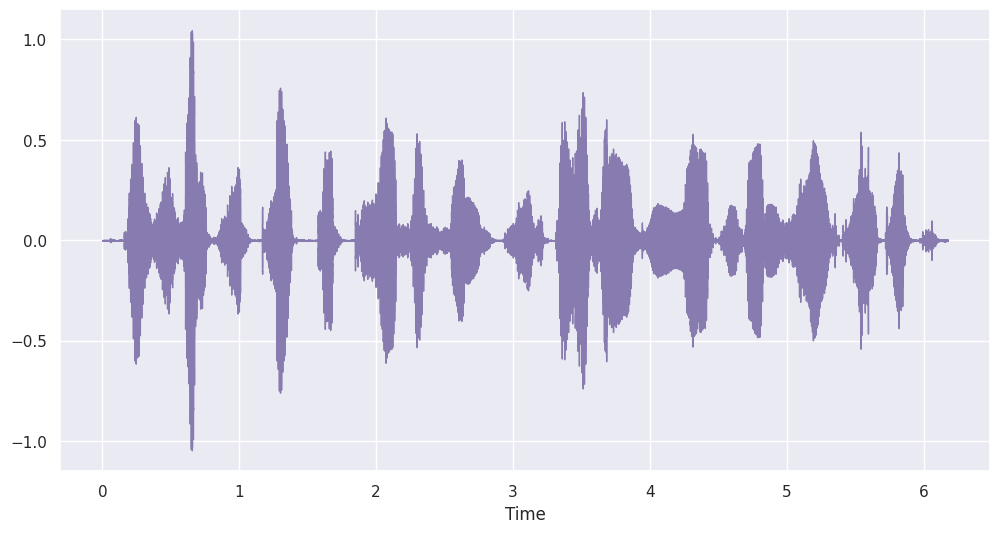

In [13]:
anxiety = audio_df[audio_df['Label'] == 'anxiety/fear']['Filepath']
anxietyarray = audio_df[audio_df['Label'] == 'anxiety/fear']['Arrays']

librosa.display.waveshow(anxietyarray.iloc[0], color='#887BB0')
IPython.display.Audio(anxiety.iloc[0])

# Hapiness

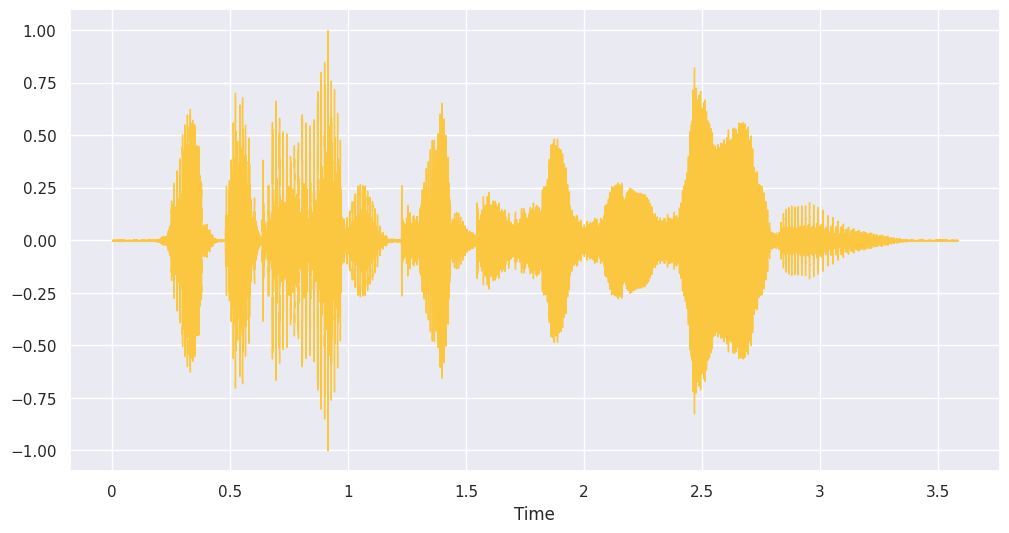

In [14]:
happiness = audio_df[audio_df['Label'] == 'happiness']['Filepath']
happinessarray = audio_df[audio_df['Label'] == 'happiness']['Arrays']

librosa.display.waveshow(happinessarray.iloc[0], color='#FBC740')
IPython.display.Audio(happiness.iloc[0])

# Neutral Version

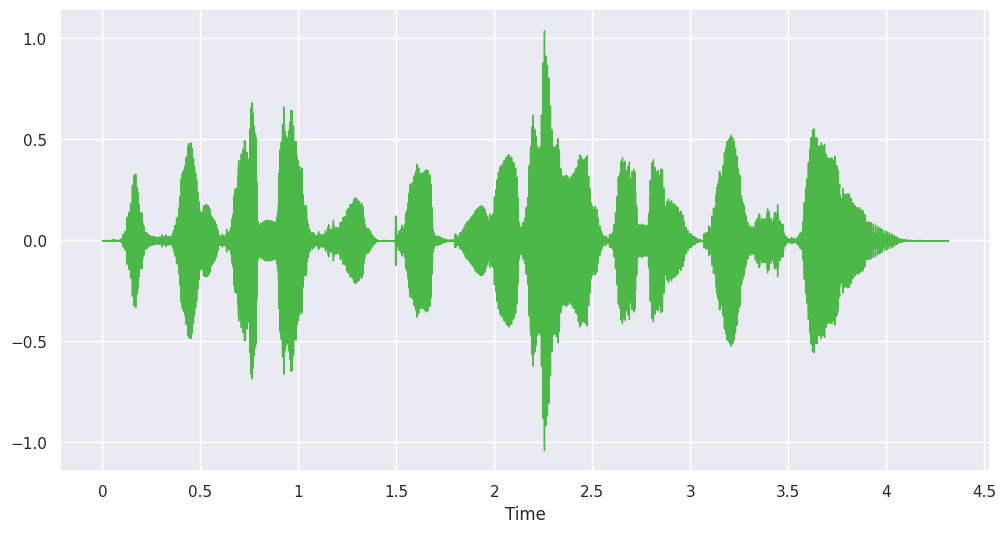

In [15]:
neutral = audio_df[audio_df['Label'] == 'neutral version']['Filepath']
neutralarray = audio_df[audio_df['Label'] == 'anger']['Arrays']

librosa.display.waveshow(neutralarray.iloc[0], color='#4CB847')
IPython.display.Audio(neutral.iloc[0])

# Data Augmentation

In [16]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps = 4)

# taking any example and checking for techniques.
path = np.array(audio_df.Filepath)[1]
data, sample_rate = librosa.load(path)

# Extracting Features

In [17]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # Duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Without AUGMENTATION
    res1 = extract_features(data)
    result = np.array(res1)
    
    # Data with NOISE
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # Data with NOISE is distinct from data with STRETCHING and PITCHING
    
    # Data with STRETCHING and PITCHING
    new_data = stretch(data, sample_rate)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [18]:
X, Y = [], []
for index, path, emotion in zip(audio_df.Index, audio_df.Filepath, audio_df.Label):
    feature = get_features(path)
    if (index % 100 == 0):
            print("Import Data: RUNNING ... {} files".format(index))
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print(len(X))
print(len(Y))
print(audio_df.Filepath.shape)
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

# Data Preparation and Normalization
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(X.shape)
print(Y.shape)

Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
1605
1605
(535,)
(1605, 162)
(1605, 7)


# Spliting Dataset

In [19]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.1)

In [20]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((1444, 162), (1444, 7), (161, 162), (161, 7))


In [21]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [22]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((1444, 162, 1), (1444, 7), (161, 162, 1), (161, 7))


# Model

In [23]:
from keras import optimizers

In [24]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 160, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 160, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 158, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 158, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 156, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 156, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 154, 1024)      │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 154, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 157696)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,740,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,972,679 (316.52 MB)

 Trainable params: 82,972,679 (316.52 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/50
 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1771 - loss: 7.9393

I0000 00:00:1713846125.211357      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713846125.232373      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.2005 - loss: 5.8936

W0000 00:00:1713846133.464148      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 845ms/step - accuracy: 0.2047 - loss: 5.7407 - val_accuracy: 0.4037 - val_loss: 1.5625
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3897 - loss: 1.6001 - val_accuracy: 0.5031 - val_loss: 1.3364
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4940 - loss: 1.3988 - val_accuracy: 0.4783 - val_loss: 1.3211
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4801 - loss: 1.3550 - val_accuracy: 0.4658 - val_loss: 1.2911
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5206 - loss: 1.2992 - val_accuracy: 0.4845 - val_loss: 1.4119
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5666 - loss: 1.1787 - val_accuracy: 0.5217 - val_loss: 1.1518
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5853 - loss: 1.1098 - val_accuracy: 0.5217 - val_loss: 1.1099
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6230 - loss: 0.9896 - val_accuracy: 0.5590 - val_loss: 

# Evaluating Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step


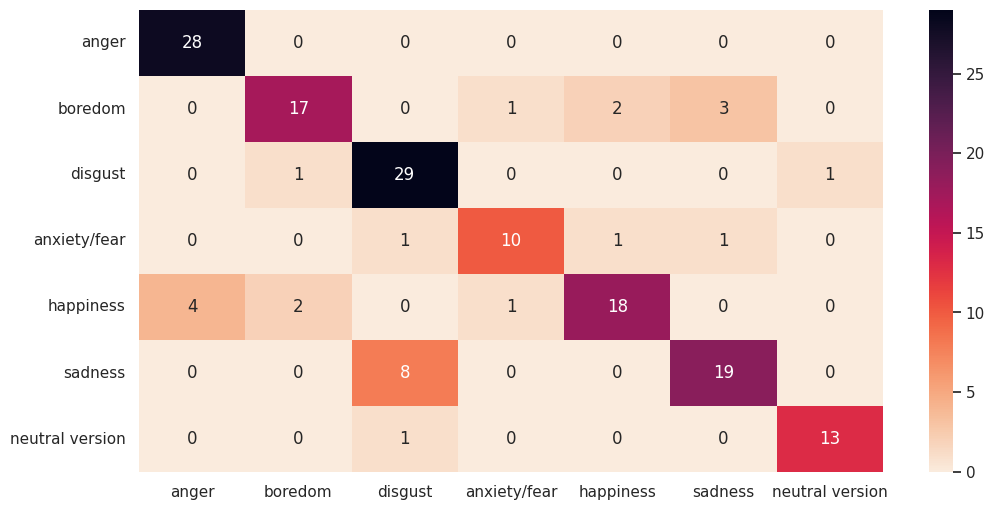

In [26]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['anger','boredom','disgust','anxiety/fear','happiness','sadness','neutral version'], yticklabels = ['anger','boredom','disgust','anxiety/fear','happiness','sadness','neutral version'])
